### The purpose of this notebook to is to recreate the regress the SSH in GLORYS onto the CWI developed in Amaya et al. (2022)

In [1]:
import os
os.chdir('/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/scripts')
plotsdir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/plots/" + x
GLORYS_dir = lambda x="": "/vortexfs1/home/anthony.meza/GLORYS_data" + x
GLORYS_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/GLORYS_processed/" + x
ERA5_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/ERA5_data/" + x

In [9]:
from help_funcs import * 
# from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import importlib
import xarray as xr
import seaborn as sns
import pandas as pd
import cmocean.cm as cm
import netCDF4 as nc
from pathlib import Path
import matplotlib.pyplot as plt
import gsw
import gc
from multiprocessing import Pool
import os 
import multiprocessing
from os.path import exists
sns.set_context("notebook")
import dask_labextension
import numpy as np
import dask
import pickle
# dask.config.set({"array.slicing.split_large_chunks": False})

In [11]:
def is_djfm(month):
    return (month >= 1) & (month <= 3) | (month == 12)

In [3]:
from multipledispatch import dispatch
@dispatch(object, object)
def prepare_IVTE_and_IVTN(DJF_phases, phase):
    IVT = xr.merge([DJF_phases["IVTE"][phase], DJF_phases["IVTN"][phase]]).sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80))
    IVT = IVT.isel(longitude = slice(0, None, 16), latitude =  slice(0, None, 14))
    IVT["IVT"] = np.sqrt(IVT["IVTE"]**2 + IVT["IVTN"]**2)
    IVT["IVT"].attrs["units"] = "(kg m)/s "
    return IVT 
@dispatch(object)
def prepare_IVTE_and_IVTN(DJF_phase):
    IVT = xr.merge([DJF_phase["IVTE"], DJF_phase["IVTN"]]).sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80))
    IVT = IVT.isel(longitude = slice(0, None, 16), latitude =  slice(0, None, 14))
    IVT["IVT"] = np.sqrt(IVT["IVTE"]**2 + IVT["IVTN"]**2)
    IVT["IVT"].attrs["units"] = "(kg m)/s "
    return IVT 

### We read in the Amaya Coastal Wave Index Amplitude $(\text{Index} =  \sqrt{\text{PC1}^2 + \text{PC2}^2)}$ and Phase $(\text{Phase} = atan( {\frac{\text{PC2}}{\text{PC1}}}))$ and recompute $\text{PC1}$ and $\text{PC2}$. We also remove the leap-year days from the GLORYS dataset.

In [134]:
def get_index_days(INDEX_TYPE):
    mxtmp_Idx = xr.open_dataset(GLORYS_data_dir("GLORYS_" + INDEX_TYPE + "_Index.nc")).sel(time = slice("1993", "2018"))
    mxtmp_Idx["ikw_amp"] = np.sqrt(mxtmp_Idx["PC1"]**2 + mxtmp_Idx["PC2"]**2)
    mxtmp_Idx_djf = mxtmp_Idx.isel(time = is_djfm(mxtmp_Idx["time.month"])); min_amp = 1.5
    indices = np.argwhere(mxtmp_Idx_djf.ikw_amp.values > min_amp).flatten()
    return mxtmp_Idx_djf.isel(time = indices).time
def get_djf_index_days(INDEX_TYPE):
    mxtmp_Idx = xr.open_dataset(GLORYS_data_dir("GLORYS_" + INDEX_TYPE + "_Index.nc")).sel(time = slice("1993", "2018"))
    mxtmp_Idx["ikw_amp"] = np.sqrt(mxtmp_Idx["PC1"]**2 + mxtmp_Idx["PC2"]**2)
    
    #obtain the phases from 0 to 360 degrees
    #measure angle from negative (-1, 0) instead of (1, 0)
    mxtmp_Idx["ikw_ph"] =  np.rad2deg(np.arctan2(mxtmp_Idx["PC2"], mxtmp_Idx["PC1"]))
    mxtmp_Idx["ikw_ph"].values[mxtmp_Idx["ikw_ph"].values < 0] +=360
    mxtmp_Idx_djf = mxtmp_Idx.isel(time = is_djfm(mxtmp_Idx["time.month"])); min_amp = 1.5
    return mxtmp_Idx_djf
def get_phases_dict(mxtmp_Idx_djf):
    phases_dict = {}
    phases_dict["1"] = np.argwhere((45 > mxtmp_Idx_djf.ikw_ph.values) & (mxtmp_Idx_djf.ikw_ph.values >=0) & (mxtmp_Idx_djf.ikw_amp.values >min_amp) )
    phases_dict["2"] = np.argwhere((90 > mxtmp_Idx_djf.ikw_ph.values) & (mxtmp_Idx_djf.ikw_ph.values >=45) & (mxtmp_Idx_djf.ikw_amp.values >min_amp) )
    phases_dict["3"] = np.argwhere((135 > mxtmp_Idx_djf.ikw_ph.values) & (mxtmp_Idx_djf.ikw_ph.values >=90) & (mxtmp_Idx_djf.ikw_amp.values >min_amp) )
    phases_dict["4"] = np.argwhere((180 > mxtmp_Idx_djf.ikw_ph.values) & (mxtmp_Idx_djf.ikw_ph.values >=135) & (mxtmp_Idx_djf.ikw_amp.values >min_amp) )
    phases_dict["5"] = np.argwhere((225 > mxtmp_Idx_djf.ikw_ph.values) & (mxtmp_Idx_djf.ikw_ph.values >=180) & (mxtmp_Idx_djf.ikw_amp.values >min_amp) )
    phases_dict["6"] = np.argwhere((270 > mxtmp_Idx_djf.ikw_ph.values) & (mxtmp_Idx_djf.ikw_ph.values >=225) & (mxtmp_Idx_djf.ikw_amp.values >min_amp) )
    phases_dict["7"] = np.argwhere((315 > mxtmp_Idx_djf.ikw_ph.values) & (mxtmp_Idx_djf.ikw_ph.values >=270) & (mxtmp_Idx_djf.ikw_amp.values >min_amp) )
    phases_dict["8"] = np.argwhere((360 > mxtmp_Idx_djf.ikw_ph.values) & (mxtmp_Idx_djf.ikw_ph.values >=315) & (mxtmp_Idx_djf.ikw_amp.values >min_amp) )
    return phases_dict

In [50]:
#read in Amaya Coastal wave index 
INDEX_TYPE = "S"
mxtmp_Idx = xr.open_dataset(GLORYS_data_dir("GLORYS_" + INDEX_TYPE + "_Index.nc")).sel(time = slice("1993", "2018"))
mxtmp_Idx["ikw_amp"] = np.sqrt(mxtmp_Idx["PC1"]**2 + mxtmp_Idx["PC2"]**2)
mxtmp_Idx_djf = mxtmp_Idx.isel(time = is_djfm(mxtmp_Idx["time.month"])); min_amp = 1.5

In [49]:
indices = np.argwhere(mxtmp_Idx_djf.ikw_amp.values > min_amp).flatten()
mxtmp_Idx_djf.isel(time = indices).time

<xarray.DataArray 'time' (time: 1107)>
array(['1993-01-12T00:00:00.000000000', '1993-01-13T00:00:00.000000000',
       '1993-01-14T00:00:00.000000000', ..., '2018-12-29T00:00:00.000000000',
       '2018-12-30T00:00:00.000000000', '2018-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1993-01-12 1993-01-13 ... 2018-12-31

In [74]:
def _preprocess_ERA5(ds):
    return ds.sel(latitude = slice(60, -2)).sel(longitude = slice(-150, -75)).sel(time = slice("1993", "2018"))

era5_anomalies = xr.open_mfdataset(GLORYS_data_dir("ERA5_AnomaliesBandPass.nc"), 
        data_vars="minimal", coords="minimal",
        compat="override", preprocess=_preprocess_ERA5,
        parallel=True, chunks={"longitude": -1, "latitude":-1, "time":320}, engine="netcdf4")



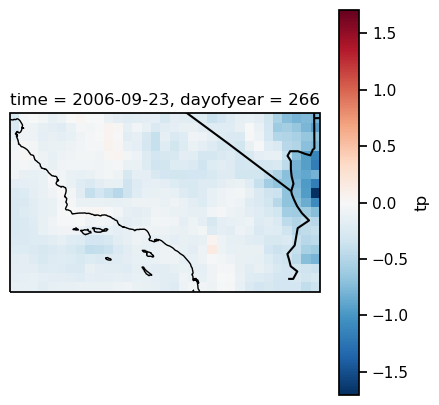

In [188]:
fig, ax = plt.subplots( figsize = (5, 5), subplot_kw={'projection': ccrs.PlateCarree()})
tp = era5_anomalies.sel(latitude = slice(37, 32.5)).sel(longitude = slice(-122, -114))
tp = tp.tp.isel(time = 5010)
tp.plot(ax = ax)
ax.coastlines()

scale = '110m'
states110 = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale=scale,
            facecolor='none',
            edgecolor='k')
ax.add_feature(states110, zorder=1, linewidth=1.5)


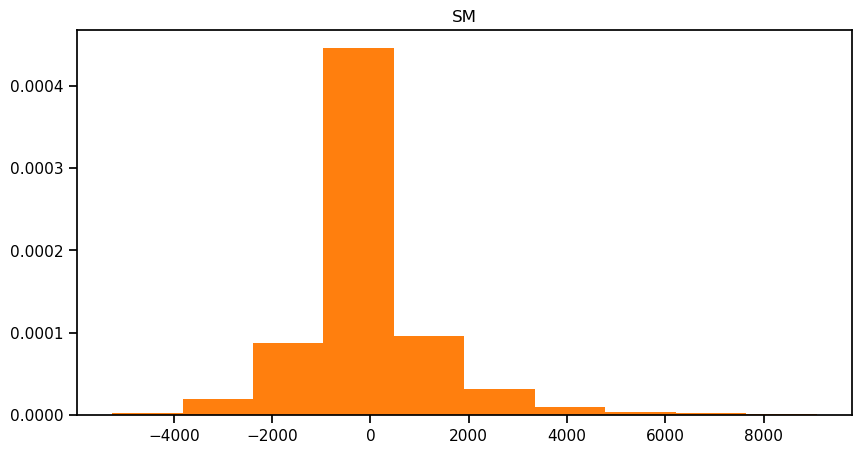

In [109]:
import copy
fig, ax = plt.subplots( figsize = (10, 5),sharey = True, sharex = True)

for (j, INDEX_TYPE) in enumerate(["S", "SM"]):
    tp = era5_anomalies.tp.sel(latitude = slice(42, 32.5)).sel(longitude = slice(-125, -115))
    cal_tp = tp.sel(latitude = slice(40, 32)).sel(longitude = slice(-125, -116))
    cal_tp = cal_tp.sum(["latitude", "longitude"])
    ax.hist(cal_tp.values, density = True)
    ax.set_title(INDEX_TYPE)

Text(0, 0.5, 'mm/day')

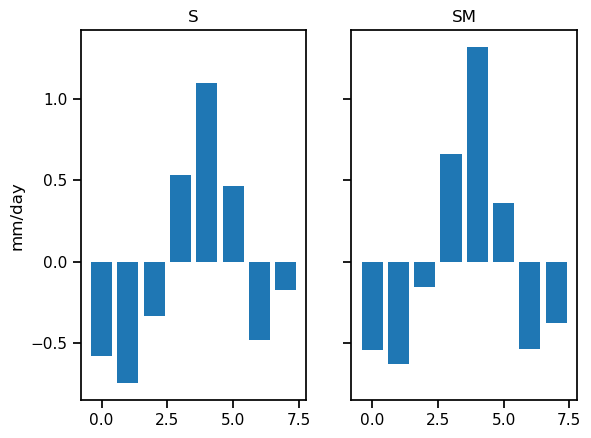

In [191]:
import copy
fig, ax = plt.subplots(1, 2, sharey = True)

for (j, INDEX_TYPE) in enumerate(["S", "SM"]):
    phases_dict, DJF_phases = read_phases(INDEX_TYPE)
    precip_hist = np.zeros(8)
    ax[j].set_title(INDEX_TYPE)
    for phase, phase_indices in phases_dict.items():
        phase_num = int(phase) - 1; i = phase_num

        Cal_Precip = DJF_phases["Precip"][phase].sel(latitude = slice(40, 32.5)).sel(longitude = slice(-125, -115))
        Cal_Precip = Cal_Precip.mean(["latitude", "longitude"])
        precip_hist[i] = copy.deepcopy(Cal_Precip)

    ax[j].bar(range(0, 8), precip_hist)
ax[0].set_ylabel("mm/day")

1.0039891
0.91376317


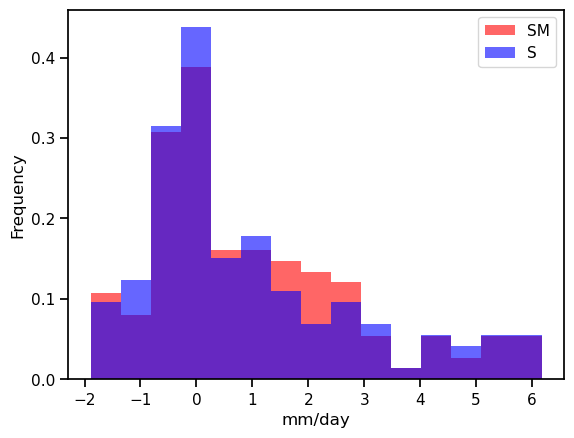

In [190]:
import copy
fig, ax = plt.subplots(sharey = True, sharex = True)
min_amp = 1.5
colors = ["red", "blue"]
for (j, INDEX_TYPE) in enumerate(["SM", "S"]):
    
    mxtmp_Idx_djf = get_djf_index_days(INDEX_TYPE)
    phase_dict = get_phases_dict(mxtmp_Idx_djf)

    phase = "5"; 
    phase_indices = phase_dict[phase]
    tp = era5_anomalies.tp.sel(latitude = slice(37, 32.5)).sel(longitude = slice(-122, -114))

    Cal_Precip = tp.isel(time = is_djfm(mxtmp_Idx["time.month"])).isel(time = phase_indices.flatten())

    Cal_Precip = Cal_Precip.mean(["latitude", "longitude"])
    print(Cal_Precip.values.mean())
    ax.hist(Cal_Precip, alpha = 0.6, color = colors[j], label = INDEX_TYPE, density = True, bins = 15)
    
    ax.set_xlabel("mm/day")
    ax.set_ylabel("Frequency")

    ax.legend()